* Make jetty bathymetry plot


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import datetime as dt
import scipy.io
import os
from salishsea_tools import nc_tools, viz_tools, tidetools, bathy_tools,geo_tools
import drifter
import matplotlib.gridspec as gridspec
import seaborn as sns
import matplotlib.colors as mcolors
sns.set(style="whitegrid")
sns.set_context("notebook", font_scale=1.6, rc={"lines.linewidth": 2.5})

In [2]:
## load bathy6
grid = nc.Dataset('/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea6.nc','r')
bathy, X, Y = tidetools.get_bathy_data(grid)
lats = grid.variables['nav_lat']
lons = grid.variables['nav_lon']
bath = grid.variables['Bathymetry']

## use actual NEMO bathymetry instead
mesh = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/oct8_101e061e05/mesh_mask.nc')
mbathy = mesh.variables['mbathy'][0,:,:] 
gdepw = mesh.variables['gdepw'][0,:,:,:]
surface_tmask = mesh.variables['tmask'][0,0,:,:]
surface_tmask = np.abs(surface_tmask-1)

bath = np.zeros(bathy.shape)
for i in np.arange(bath.shape[1]):
    for j in np.arange(bath.shape[0]):
        level = mbathy[j,i]
        bath[j,i] = gdepw[level,j,i]
bath = np.ma.masked_array(bath, mask = surface_tmask)
mesh.close()

In [3]:
## load jetty bathymetry
#bathy_10 = nc.Dataset('/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea10.nc','r' )
#bathyy_10 = bathy_10.variables['Bathymetry']
#lon_10 = bathy_10.variables['nav_lon']
#lat_10 = bathy_10.variables['nav_lat']
mesh = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/oct8_10jetty1e0605/mesh_mask.nc')

mbathy = mesh.variables['mbathy'][0,:,:] 
gdepw = mesh.variables['gdepw'][0,:,:,:]
surface_tmask = mesh.variables['tmask'][0,0,:,:]
surface_tmask = np.abs(surface_tmask-1)

bathyy_10 = np.zeros(bathy.shape)
for i in np.arange(bathyy_10.shape[1]):
    for j in np.arange(bathyy_10.shape[0]):
        level = mbathy[j,i]
        bathyy_10[j,i] = gdepw[level,j,i]
bathyy_10 = np.ma.masked_array(bathyy_10, mask = surface_tmask)
mesh.close()

In [4]:
## load drifter
drifters = scipy.io.loadmat('/ocean/mhalvers/research/drifters/SoG_drifters.mat',squeeze_me=True)
ubc = drifters['ubc']

In [5]:
## load particle
drop = 'drop1/12'
runs=['oct8_10RFdailySmoo','oct8_10jetty1e0605']
base='/ocean/jieliu/research/meopar/Ariane/result/'
file_pattern = 'ariane_trajectories_qualitative.nc'
lon112 = {}; lat112={}
for run in runs:
    path = os.path.join(base,run, drop,file_pattern)
    f = nc.Dataset(path,'r');
    lon112[run] = f.variables['traj_lon']
    lat112[run] = f.variables['traj_lat']

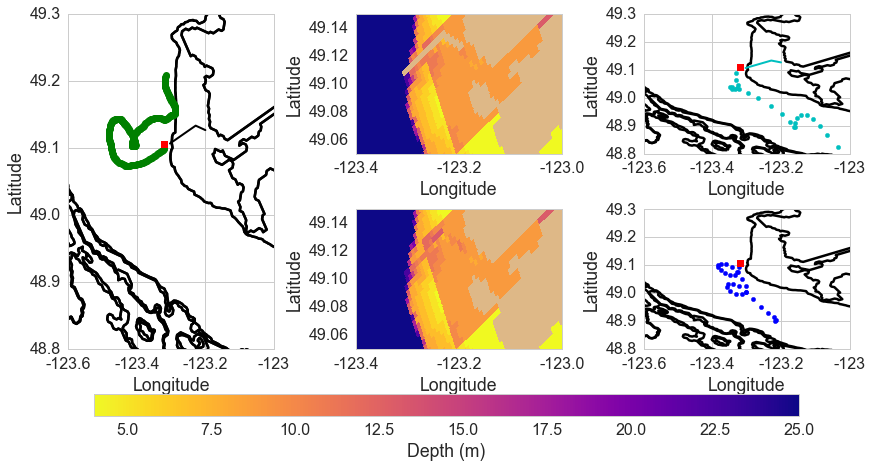

In [6]:
colour_map=plt.get_cmap('plasma_r');
land_colour='burlywood'
colour_map.set_bad(land_colour)

fig = plt.figure(figsize=(14,6))
gs = gridspec.GridSpec(2, 3,width_ratios=[0.8,0.8,0.8], height_ratios=[1,1])  
gs.update(hspace=0.4, wspace=0.4)
ax1 = fig.add_subplot(gs[:,0])
ax2 = fig.add_subplot(gs[0,2])
ax3 = fig.add_subplot(gs[1,2])
ax4 = fig.add_subplot(gs[0,1])
ax5 = fig.add_subplot(gs[1,1])

ax = ax1 ## drifter plot
buoy = 2
name, tracks=drifter.organize_info(buoy,ubc)
startdate = dt.datetime(2014,10,8)
day = 8
hour = 22
i = -1
fancy = False
ind =drifter.find_start(tracks,startdate)
traj=tracks[ind[i]]
duration = (traj['time'][-1]-traj['time'][0]).total_seconds()/3600
random_time = dt.datetime(2014, 10, day, hour)
lonn = []
latt = []
ax.plot(traj['lon'],traj['lat'],'og')
ax.plot(traj['lon'][0],traj['lat'][0],'sr')
ax.set_xlim([-123.6,-123])
ax.set_ylim([48.8,49.3])
ax.set_xticks([-123.6, -123.4, -123.2,-123])
ax.set_xticklabels([-123.6, -123.4, -123.2,-123])
ax.plot(-123-np.array([18.2, 13.7, 12])/60.,49+np.array([6.4, 8, 7.6])/60.,'-k',lw=2); 
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
viz_tools.plot_coastline(ax, grid, coords='map')
viz_tools.plot_coastline(ax, grid, coords='map',isobath=20)


ax= ax2 ## upper right jetty bathy particle
key = 'oct8_10jetty1e0605'
part = 0
ax.scatter(lon112[key][1:,part],lat112[key][1:,part],marker='o',color='c',label=key)
ax.plot(lon112[key][0,part],lat112[key][0,part],'sr')
ax.plot(-123-np.array([18.2, 13.7, 12])/60.,49+np.array([6.4, 8, 7.6])/60.,'-c',lw=2); 


ax = ax3 ## lower right bathy6 particle
key = 'oct8_10RFdailySmoo'
part = 0
ax.scatter(lon112[key][1:,part],lat112[key][1:,part],marker='o',color='b',label=key)
ax.plot(lon112[key][0,part],lat112[key][0,part],'sr')

ax= ax4## upper middle jetty bathy 
mesh = ax.pcolormesh(lons[:], lats[:], bathyy_10[:], cmap=colour_map, vmin=4, vmax=25)


ax = ax5 ## lower middle bathy6
mesh = ax.pcolormesh(lons[:], lats[:], bath[:], cmap=colour_map, vmin=4, vmax=25)

cbar_ax = fig.add_axes([0.15, -0.03, 0.7, 0.05]) ## set colorbar
cbar = fig.colorbar(mesh, cax=cbar_ax, orientation = 'horizontal')
cbar.set_label('Depth (m)')

for ax in [ax1,ax2,ax3]:
    viz_tools.plot_coastline(ax, grid, coords='map')
    viz_tools.plot_coastline(ax, grid, coords='map',isobath=20)
    ax.set_xlim([-123.6,-123])
    ax.set_ylim([48.8,49.3])
    ax.set_xticks([-123.6, -123.4, -123.2,-123])
    ax.set_xticklabels([-123.6, -123.4, -123.2,-123])
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    
for ax in [ax4,ax5]:
    ax.set_xlim(-123.4, -123)
    ax.set_ylim([49.05, 49.15])
    ax.set_xticks([-123.4,-123.2,-123])
    ax.set_xticklabels([-123.4,-123.2,-123.])
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')